First let's load the Jar. This requires `mill q.assembly` to be run beforehand.

In [1]:
interp.load.cp(os.pwd/".."/"out"/"q"/"assembly.dest"/"out.jar")

We will load some boilerplate code for graphing as well.

In [2]:
import $file.makeplot

import $file.$

Now, all the imports...

In [3]:
import riscq._
import riscq.tester.qubic._
import riscq.soc.QubicSoc
import riscq.tester._
import spinal.core.sim._
import spinal.core._
import spinal.lib.bus.tilelink.sim._
import spinal.lib.bus.tilelink._
import spinal.lib.bus.amba4.axi.sim.Axi4Master
import riscq.tester.RvAssembler
import riscq.tester.QubicAssembler
import riscq.tester.ByteHelper
import riscq.soc.QubicPlugins
import QubicTestConfig._
import scala.collection.mutable.ArrayBuffer

import riscq._
import riscq.tester.qubic._
import riscq.soc.QubicSoc
import riscq.tester._
import spinal.core.sim._
import spinal.core._
import spinal.lib.bus.tilelink.sim._
import spinal.lib.bus.tilelink._
import spinal.lib.bus.amba4.axi.sim.Axi4Master
import riscq.tester.RvAssembler
import riscq.tester.QubicAssembler
import riscq.tester.ByteHelper
import riscq.soc.QubicPlugins
import QubicTestConfig._
import scala.collection.mutable.ArrayBuffer

First, let's copy over the existing QubicSOC test and collect some output. This skips hand-writing assembly for the moment.

In [4]:
val dac_output = ArrayBuffer[Double]()
val carrier_output = ArrayBuffer[Double]()
simConfig
    .compile{
      val dut = QubicSoc(
        qubitNum = 8,
        withVivado = false,
        withCocotb = false,
        withWhitebox = true,
        withTest = true
      )
      dut.pgs.map{_.io.simPublic()}
      dut.cgs.map{_.io.simPublic()}
      dut
    }
    .doSim { dut =>
      val driver = new Driver(dut)
      import driver._
      val rvAsm = new RvAssembler(128)
      import rvAsm._
      val qbAsm = new QubicAssembler()
      import qbAsm._

      init()

      val batchSize = 16
      val dataWidth = 16
      for (i <- 0 until 100) {
        val dt = if (i == 0) BigInt(10) else BigInt(1000)
        val batch = List.fill(batchSize)(dt)
        val batchData = riscq.pulse.PGTestPulse.concat(batch, dataWidth)
        val dataStr = batch.map { x => ByteHelper.intToBinStr(x, dataWidth) }.reduce { _ ++ _ }
        tlDriver.putFullData(0, dut.pulseOffset + i * batchSize * dataWidth / 8, ByteHelper.fromBinStr(dataStr).reverse)
      }
      cd100m.waitRisingEdge()

      val startTime = 50
      val insts = List(
        setTime(0), // 0
        carrier(1 << (16 - 5), 0), // 1
        qbAsm.pulse(
          puop,
          start = startTime,
          addr = 0,
          duration = 4,
          phase = (1 << (puop.phaseWidth - 7)),
          freq = 0,
          amp = (1 << (puop.ampWidth - 1)) - 1
        ), // 2
        beq(0, 0, 0) // 3
      )
      loadIMem(0, insts)

      dut.riscq_rst #= true
      tick()
      dut.riscq_rst #= false

      tick(startTime+8)
      for (i <- 0 until 20) {
        logTime()
        logPcs()
        logDac(0)
        logCarrier(0)
        println("")
        val dac = dut.pgs(0).io.data
        val pulse = dac.payload.map { _.r.toDouble * (1 << 14) }.toList
        dac_output ++= pulse
        val carrier = dut.cgs(0).io.carrier
        val data = carrier.payload.map { _.r.toDouble * (1 << 14) }.toList
        carrier_output ++= data
        tick()
      }
    }

[Runtime] SpinalHDL dev    git head : c500e9bcb2f06463b7316b3365330612a6487980
[Runtime] JVM max memory : 3910.0MiB
[Runtime] Current date : 2025.04.02 17:33:26
[Progress] at 0.000 : Elaborate components
debug jumps: ArrayBuffer(toplevel/riscqArea_riscq/null)
########################1
debug hazard ctrlrange: Range 0 to 0
debug hazard ds: 0
!!!!!!!!!!!!!###########Range 0 until 2
!!!!!!!!!!!!!###########Range 0 until 2
[Progress] at 4.525 : Checks and transforms
[Progress] at 9.463 : Generate Verilog to ./simWorkspace/tmp/job_1
[Warning] toplevel/riscqArea_riscq/integer_RegFilePlugin_logic_regfile_fpga/asMem_ram : Mem[32*32 bits].readAsync can only be write first into Verilog
[Warning] toplevel/riscqArea_riscq/integer_RegFilePlugin_logic_regfile_fpga/asMem_ram : Mem[32*32 bits].readAsync can only be write first into Verilog
[Warning] toplevel/rbBusLogic_rbTlWa_logic_bridge/upsize_d_ctx/contexts : Mem[8*2 bits].readAsync can only be write first into Verilog
[Warning] toplevel/cd100mLogic

List(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)
List(-16383.0, -16068.0, -15136.0, -13622.0, -11584.0, -9102.0, -6269.0, -3196.0, 0.0, 3197.0, 6270.0, 9103.0, 11585.0, 13623.0, 15137.0, 16069.0)

time: 60
pc 80000050, v: true, r: true, f: false, fetch0
pc 80000040, v: true, r: true, f: false, fetch1
pc 80000030, v: true, r: true, f: false, decode0
pc 80000070, v: false, r: true, f: false, pre_execute_1
pc 80000060, v: false, r: true, f: false, execute0
pc 80000050, v: false, r: true, f: false, execute1
pc 80000040, v: false, r: true, f: false, execute2
List(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)
List(16382.0, 16067.0, 15135.0, 13621.0, 11583.0, 9101.0, 6268.0, 3195.0, 0.0, -3197.0, -6270.0, -9103.0, -11585.0, -13623.0, -15137.0, -16069.0)

time: 61
pc 80000060, v: true, r: true, f: false, fetch0
pc 80000050, v: true, r: true, f: false, fetch1
pc 80000040, v: true, r: true, f: true, decode0
pc 80000030, v: tru

dac_output: ArrayBuffer[Double] = ArrayBuffer(
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  8.0,
  8.0,
  8.0,
  7.0,
  6.0,
  4.0,
  3.0,
  1.0,
  -1.0,
  -3.0,
  -4.0,
  -6.0,
  -7.0,
  -8.0,
  -9.0,
  -9.0,
  -998.0,
  -970.0,
  -904.0,
  -803.0,
  -671.0,
  -514.0,
...
carrier_output: ArrayBuffer[Double] = ArrayBuffer(
  -16383.0,
  -16068.0,
  -15136.0,
  -13622.0,
  -11584.0,
  -9102.0,
  -6269.0,
  -3196.0,
  0.0,
  3197.0,
  6270.0,
  9103.0,
  11585.0,
  13623.0,
  15137.0,
  16069.0,
  16382.0,
  16067.0,
  15135.0,
  13621.0,
  11583.0,
  9101.0,
  6268.0,
  3195.0,
  0.0,
  -3197.0,
  -6270.0,
  -9103.0,
  -11585.0,
  -13623.0,
  -15137.0,
  -16069.0,
  -16383.0,
  -16068.0,
  -15136.0,
  -13622.0,
  -11584.0,
  -9102.0,
...

Now, let's graph the DAC and Carrier data.

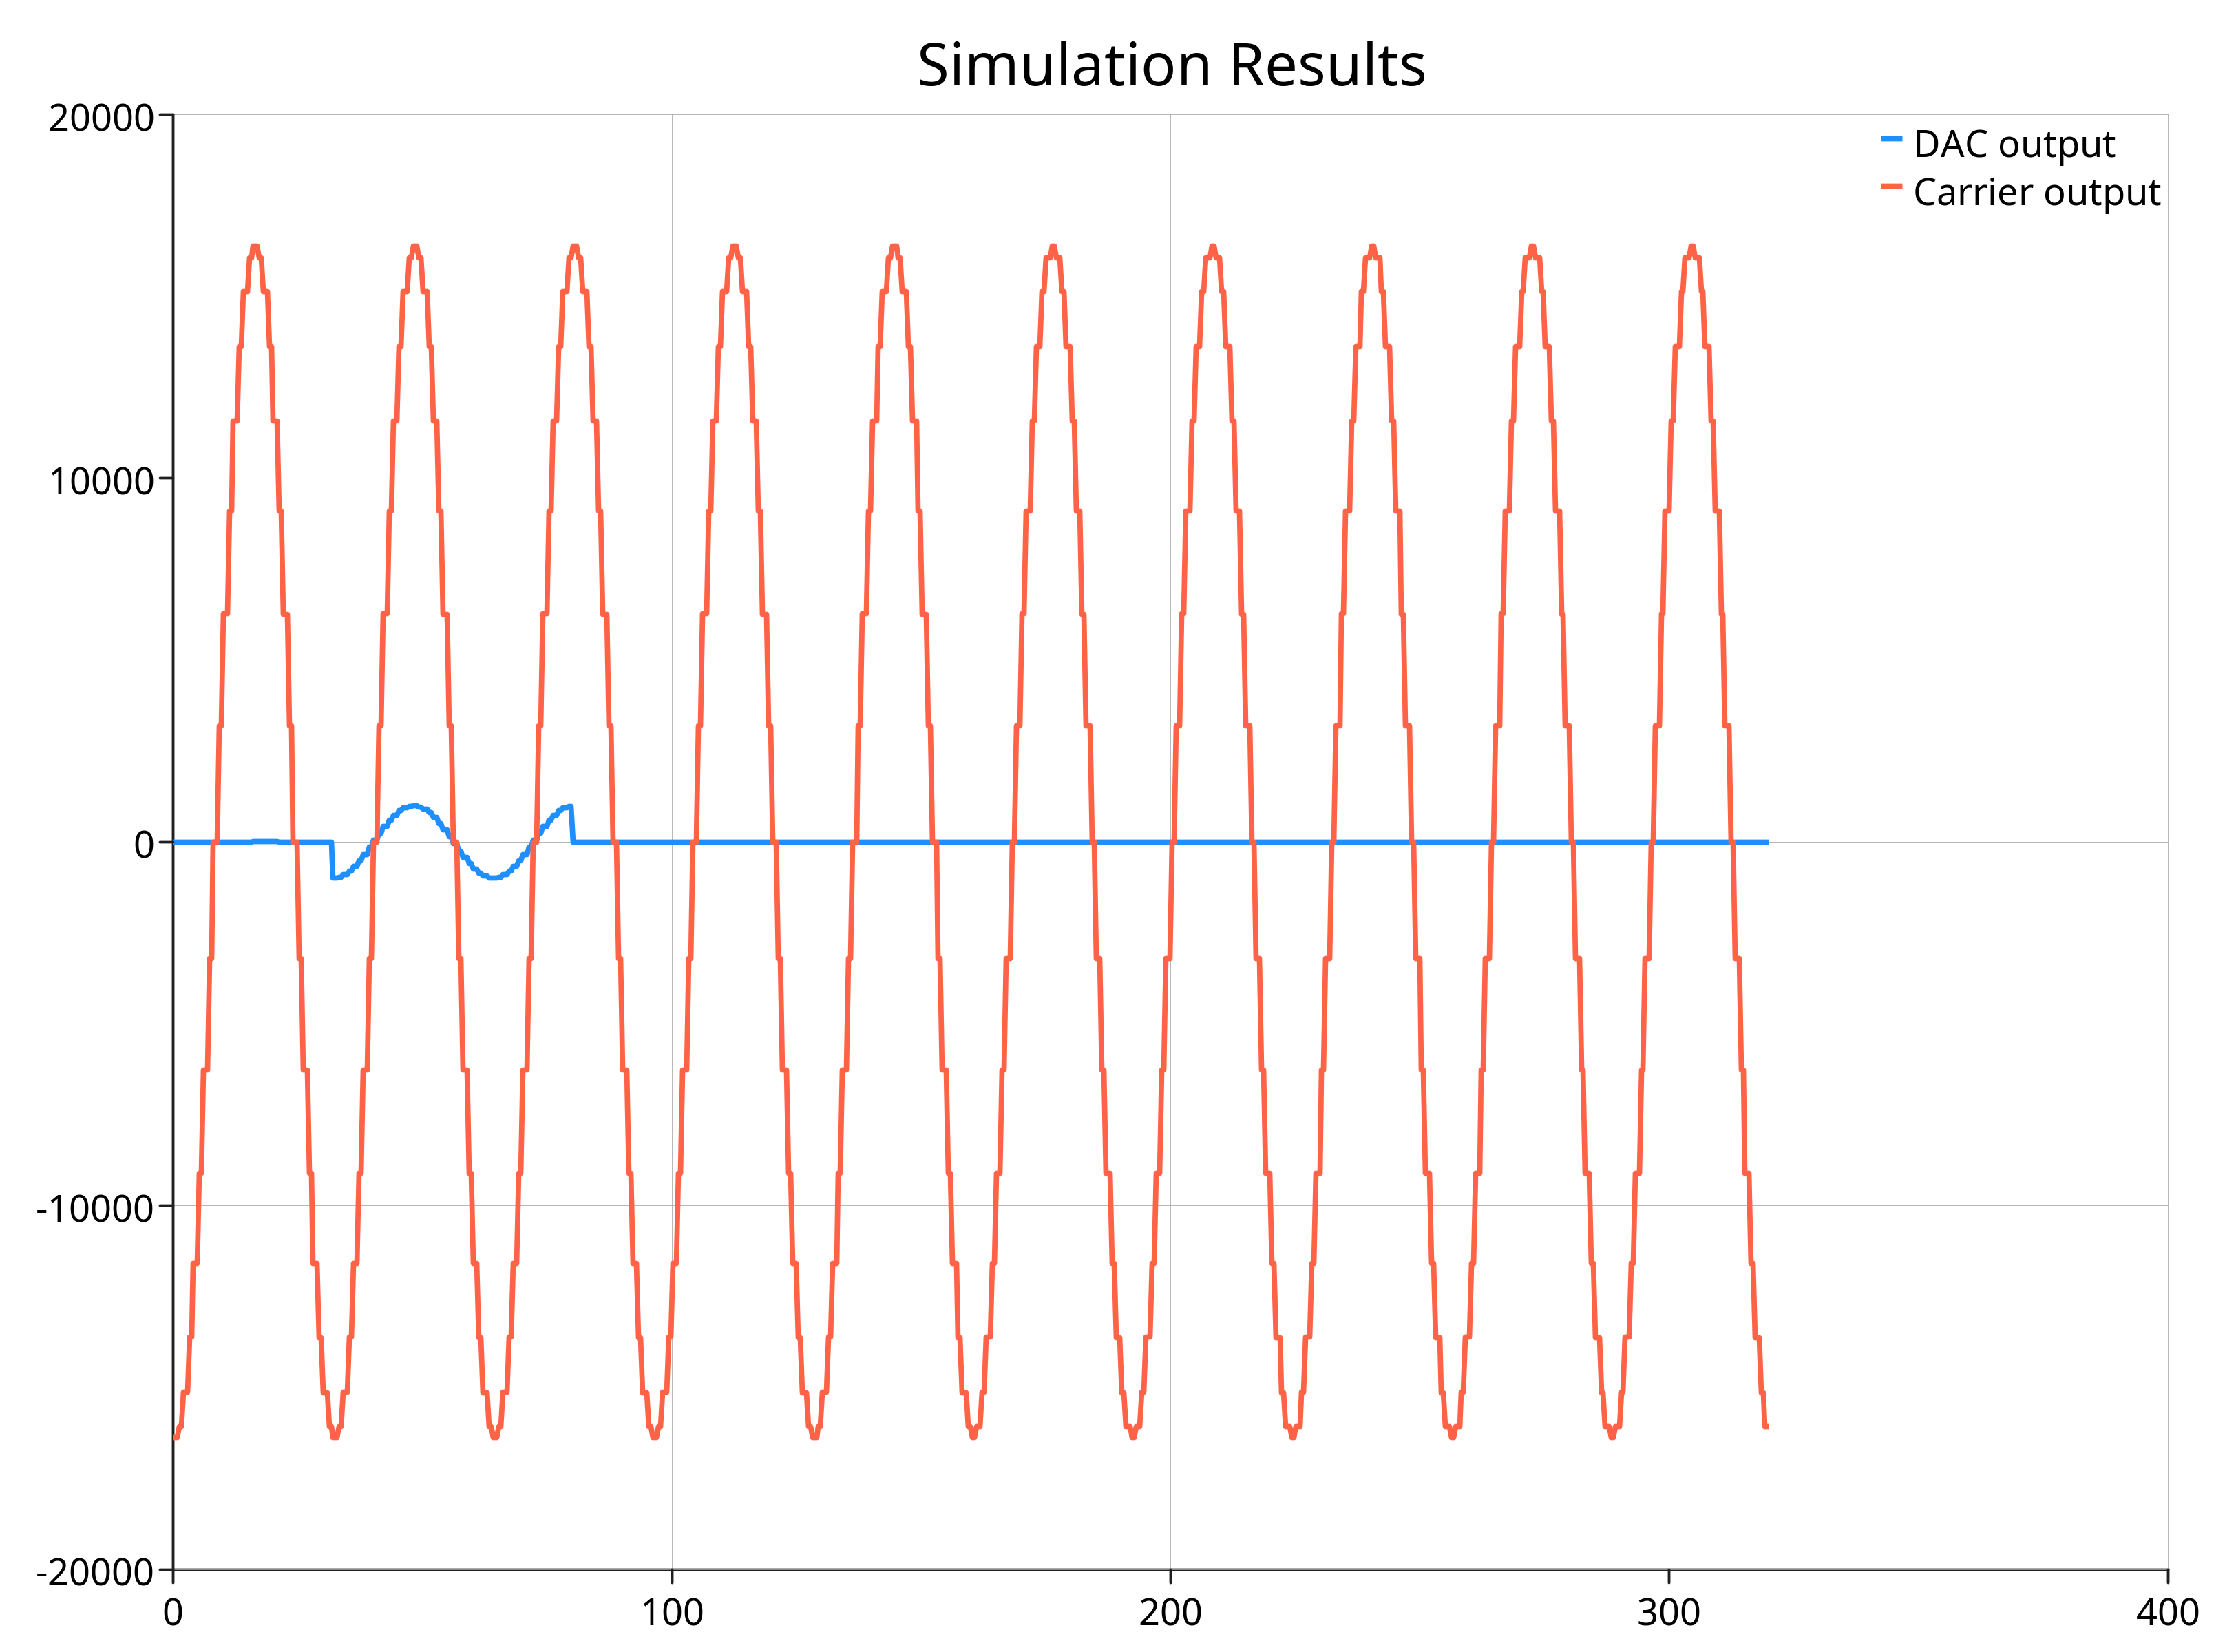

pngBytes: Array[Byte] = Array(
  -119,
  80,
  78,
  71,
  13,
  10,
  26,
  10,
  0,
  0,
  0,
  13,
  73,
  72,
  68,
  82,
  0,
  0,
  12,
  -80,
  0,
  0,
  9,
  96,
  8,
  6,
  0,
  0,
  0,
  34,
  11,
  47,
  101,
  0,
  0,
  -128,
  0,
  73,
...

In [5]:
val pngBytes = makeplot.make_plot(List(makeplot.LabeledData("DAC output", dac_output), makeplot.LabeledData("Carrier output", carrier_output)))
Image(pngBytes)

Now, let's fix the envelope and do the same!

In [5]:
// TODO

And now we write some assembly and try the same with MMSoc too. TODO for this to work, need to run some build script in the "asm" folder.

In [5]:
// TODO

Graph it too.